## Agent Initiation Tests

Load the environment variables with groq api key

In [1]:
from dotenv import load_dotenv
load_dotenv('.env', override=True)

True

In [2]:
from langchain.chat_models import init_chat_model

llm_groq = init_chat_model('groq:llama-3.1-8b-instant',temperature = 0)

In [3]:
result = llm_groq.invoke("Hey what's up!")
print(result.content) # Should print the response from the model

Not much, just here to help with any questions or topics you'd like to discuss. How's your day going so far?


In [7]:
print(result)

content="Not much, just here to help with any questions or topics you'd like to discuss. How's your day going so far?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 40, 'total_tokens': 67, 'completion_time': 0.020478351, 'prompt_time': 0.006143241, 'queue_time': 0.139438791, 'total_time': 0.026621592}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--9ba54d12-cfb0-4bac-b415-5eeb357448de-0' usage_metadata={'input_tokens': 40, 'output_tokens': 27, 'total_tokens': 67}


# Tool calling Langchain

In [9]:
from langchain.tools import tool

@tool
def add_numbers(a:int, b:int) -> int:
    """Function to add two numbers"""
    return(a+b)

type(add_numbers)

langchain_core.tools.structured.StructuredTool

In [10]:
add_numbers.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

# Tool Binding with Langchain

In [ ]:
model_with_tools = llm_groq.bind_tools([add_numbers], tool_choice ="any")
output = model_with_tools.invoke("What is 5 + 2?")
print(output)

content='' additional_kwargs={'tool_calls': [{'id': '7zc5mgd8g', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add_numbers'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 242, 'total_tokens': 259, 'completion_time': 0.041566838, 'prompt_time': 0.100818023, 'queue_time': 0.044645997, 'total_time': 0.142384861}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ebca78bc-aa78-4aad-9965-0bf4071d98eb-0' tool_calls=[{'name': 'add_numbers', 'args': {'a': 5, 'b': 2}, 'id': '7zc5mgd8g', 'type': 'tool_call'}] usage_metadata={'input_tokens': 242, 'output_tokens': 17, 'total_tokens': 259}


In [14]:
args = output.tool_calls[0]['args']
args

{'a': 5, 'b': 2}

In [15]:
result = add_numbers.invoke(args)
print(result)

7


# LangGraph Function testing/Re-learning

In [13]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict): # Define class of the graph and parameters datatype and co-rellation
    message: str
    
def greeting_node(state: AgentState) -> AgentState:
    """Simple function/node to greet the user"""
    
    state['message'] = "Hey " + state["message"] + " how is your day going?"
    
    return state


In [14]:
graph = StateGraph(AgentState)

graph.add_node("Greeter", greeting_node)

graph.set_entry_point("Greeter")
graph.set_finish_point("Greeter")

app = graph.compile()

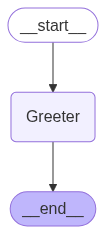

In [15]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
result = app.invoke(AgentState(message="Gideon"))

In [17]:
result["message"]

'Hey Gideon how is your day going?'

# Test 2 (Exercise, Compliment Agent)

In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph

class StateAgent(TypedDict): # Defining Agent state for carry-forward
    compliments: str
    
def complimenting_node(state:StateAgent) -> StateAgent:
    """ Function to compliment the user """
    state["compliments"] = state["compliments"] + "," + " you're doing an amazing job learning LangGraph!"
    
    return state

graph = StateGraph(StateAgent)

graph.add_node("Complimenter", complimenting_node)

graph.set_entry_point("Complimenter")
graph.set_finish_point("Complimenter")

app = graph.compile()

result = app.invoke(StateAgent(compliments="Gideon"))

print(result["compliments"])

    

Gideon, you're doing an amazing job learning LangGraph!


# Test Graph 3 (Multiple Inputs Graph)

Hi Gideon, your answer is 120


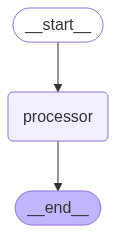

In [28]:
from typing import TypedDict
from langgraph.graph import StateGraph

class MultiInputAgent(TypedDict):
    name:str
    values: list[int]
    operation: str
    result: str
    
def Processor_node(state:MultiInputAgent) -> MultiInputAgent:
    """ Function to process Multiple type of inputs """
    if state["operation"] == "+":
        state["values"] = sum(state["values"])
    elif state["operation"] == "*":
        product = 1
        for value in state["values"]:
            product *= value
        state["values"] = product
        
    state["result"] = "Hi " + state["name"] + ", your answer is " + str(state["values"])
    
    return state

graph = StateGraph(MultiInputAgent)
graph.add_node("processor", Processor_node)
graph.set_entry_point("processor")
graph.set_finish_point("processor")

app = graph.compile()

result = app.invoke(MultiInputAgent(name="Gideon", values = [1,2,3,4,5], operation = "*"))

print(result["result"])

display(Image(app.get_graph().draw_mermaid_png()))

      

# Offline LLM Test (Llama3.2 via Ollama)